# An Introduction to the Immersed Boundary Method

In this notebook, we introduce + demonstrate a simple 2D immersed boundary method. We simulate the *fluid-structure interaction* for an elastic fiber immersed in an incompressible fluid. 

## The Fluid
In general, we can model a fluid via the incompressible Navier Stokes equations:

$ \rho(\partial_t + \vec{u}\cdot\vec{\nabla})\vec{u} = \mu\nabla^2 \vec{u} - \vec{\nabla} P + \rho\vec{f}$

$\vec{\nabla}\cdot\vec{u}=0$

with density $\rho$ and velocity $u$, viscosity $\mu$, pressure $P$, and where $f$ is an external force density. 

We can easily solve these equations on a grid using any fluid solver - in this code, we use fast fourier transforms (fft's). The original code was written for periodic boundary conditions, but can (in certain circumstances) be generalized to allow Dirichlet or Neumann boundary conditions by taking the edges as ghost cells, which we update between iterations. 

## The Solid
NS are difficult to solve for complex boundary conditions, so modeling the flow around a strangely shaped obstacle - especially a deformable obstacle - is difficult. This is where the Immersed Boundary Method comes in. 

We treat the boundary as a set of Lagrangian points $X$ which move at the fluid velocity $U$ (i.e. no-slip) and are connected by springs of stiffness $K$. Then, to model the fluid-structure interaction, the elastic force felt at each boundary point is then exerted locally onto the fluid. Since the only effect of the boundary on the fluid is to exert an external force, NS can be solved for a fluid without the geometry of the boundary. 

Crucially, the fluid $u$ is modeled on an *eulerian* grid, while the *lagrangian* boundary points $X$ are generally off-grid. A *discrete dirac-delta function* can be used to transform from the eulerian grid to the lagrangian boundary, and vice versa. In particular, to calculate the Lagrangian boundary velocity $U$ , we can *interpolate* the nearby Eulerian velocities $u$; and likewise, we can *spread* the elastic Lagrangian force $F$ onto the nearby eulerian gridpoints to exert a force density $f$. 

Here, we use the four-point dirac-delta function constructed by Peskin - which effectively means we interpolate to / spread from the nearest 4x4(x4) Eulerian points, with the appropriate weights. 

## Implementation

 The immersed boundary method generally proceeds as follows:

- At each timestep, we interpolate the local fluid velocity $u(t)$ to find the boundary velocity $U(t)$ and then estimate the new boundary position $X$


- The elastic force at the new boundary point $X_k$ is $F_k \approx K(X_{k+1}-X_k) + K(X_k-X_{k-1})$. At each boundary point, we spread this force to the fluid and then solve Navier Stokes with the resulting external force density $f$ to compute the new fluid velocity $u$


To properly model the time evolution of the system, we must calculate both the velocity of the fluid $u^{n+1}$ and the position of the immersed boundary $X^{n+1}$ at each timestep. Since the boundary motion is determined by the fluid velocity, and force exerted on the fluid is determined by the boundary position, calculating both of these simultaneously is tricky. Consequently, we *iterate* the system by first computing the boundary position at a *half* timestep $X^{n+1/2}$, and use the resulting 'midpoint' force $F^{n+1/2}$ to compute both the updated fluid velocity $u^{n+1}$, and the 'midpoint' fluid velocity $u^{n+1/2}$ used to compute the updated boundary position $X^{n+1}$. Explicitly,

- We first compute the *midpoint* boundary position  $XX = X(t+\frac{dt}{2} \approx X(t)+\frac{dt}{2}U(t)$, and then compute the force density $ff$ at the midpoint. 
- We then solve Navier Stokes subject to $ff$ to find both the updated fluid velocity $u(t+dt)$; and the midpoint fluid velocity $uu\equiv u(t+\frac{dt}{2})$
- Finally, we interpolate $uu$ to find the midpoint boundary velocity $UU \equiv U(t+\frac{dt}{2})$, and the updated boundary $X(t+dt) = X(t) + UUdt$


# Benchmarking the Fluid Solver: Poisseuille Flow

To start, let's simulate a flow through a channel by setting $u_x=1, u_y=0$ at the top and the bottom:

<IPython.core.display.Javascript object>


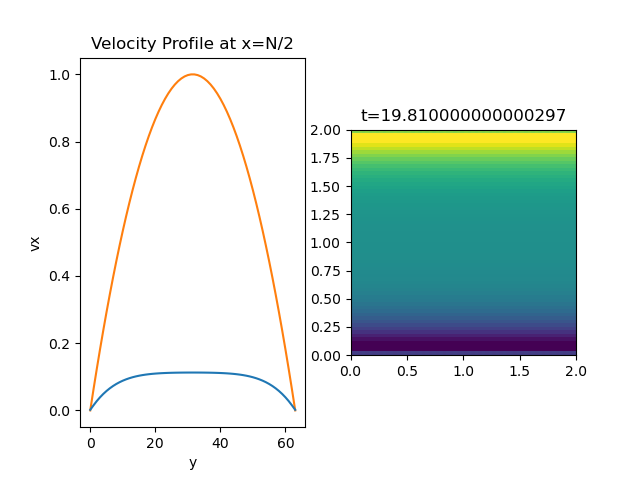

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.writer'] = animation.writers['pillow']
ani_path = 'tutorial_figures/'
%matplotlib notebook 

from ib2 import IB2
from fluid2 import FLUID    #### Generic fluid solver
    
import warnings; warnings.simplefilter('ignore')

########  Simulate pressure-driven flow in no-slip channel    #############

#### Initialization of Fluid+Boundary Conditions
fluid = FLUID(L=2.)

def channel(u):
    u[0][:, 0] = 0.
    u[0][:,-1] = 0.

    u[1][:, 0] = 0.
    u[1][:,-1] = 0.
    
fluid.boundary = channel    ## No-slip channel

inlet_pressure = 0*fluid.u
inlet_pressure[0][0, :] = 1.    ## External force density is pressure-driven flow at inlet

fig = plt.figure()

# Velocity Profile
ax = fig.add_subplot(1,2,1)
plt.title('Velocity Profile at x=N/2')
plt.xlabel('y')
plt.ylabel('vx')

cmap = plt.get_cmap('tab10')
y = np.linspace(0, fluid.L, fluid.N)
u_theo = -1.*y*(y-fluid.L)
profile_theo = ax.plot(u_theo, color=cmap(1))

#### Vorticity Map
ax2 = fig.add_subplot(1, 2, 2)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

ims = []
for i in range(2000):
    fluid.t += fluid.dt
    uu = fluid.step_u(inlet_pressure)
    if i%20==0:
        #Velocity Profile
        im = ax.plot(fluid.u[0][int(fluid.N/2), :], color=cmap(0))  ## ax.plot returns a list of 2DLines (e.g. list of artists)
        im.extend(profile_theo)

        # Vorticity Map
        im.append(fluid.show_vorticity(ax2))     #### show_vorticity returns output from plt.imshow(), which is an artist
        im.append(ax2.set_title('t={}'.format(1*fluid.t)))
        ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
ani.save(ani_path+'2D_pois_vanilla.gif', writer='pillow')

plt.show()

u_pois = fluid.u

And we see that we get a poisseuille flow profile, as expected.

## Reynolds Number

In the specific case of flow through a pipe, the flow profile has the analytic form $v_x = \frac{Gy^2}{4\mu}$, where $y$ is the distance from the center of the pipe, and $G\equiv\Delta P/L$ is dependent on the pressure gradient.

Plugging in our boundary condition that the walls are moving at $u_0$ at a $y=L_y/2$, we have 

$u_0 = \frac{G(L/2)^2}{4\mu}$, and $v_x = u_0\big(\frac{2y}{L_y}\big)^2$

This allows us to quantify Reynolds number and the scale of the inlet flow $G$ in terms of system parameters.

# 2D Elastic Boundaries
Next, we simulate an actual immersed boundary. We take the poisseuille flow we established in the previous simulation, and put two elastic, circular boundaries in it. The boundary points are off-grid, move at the local fluid velocity, and are connected to each other by simple springs. 

We write a (commented-out) method which shows explicitly how the midpoint-method time-iteration works, but in general it is easier to use the built-in functions. ib2 has step_XX and step_X to update $XX$ and $X$ respectively, and $ib2.ff$ returns the midpoint force Force(XX) spread to the fluid at the points XX. Likewise, fluid.step_u updates the fluid velocity u and returns the midpoint velocity uu. 

In [2]:
#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids, ext=None):
    dt = fluid.dt
    fluid.t += dt
    
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX) # Force at midpoint # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    if ext is not None:   ## External force on fluid.    **NOTE: add this after the solid forces (not before), otherwise numpy gets cranky
        ff += ext
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)                        # built-in function            
        


Next, we illustrate a general procedure for modeling a system:
1) Initialize the fluid and fluid parameters (L, $\rho$, $\eta$, etc) and fields (i.e. $\vec{u}$)

2) Initialize the immersed boundary(ies) and specify relevant parameters (i.e. $K$)

3) Iterate the system in time


<IPython.core.display.Javascript object>


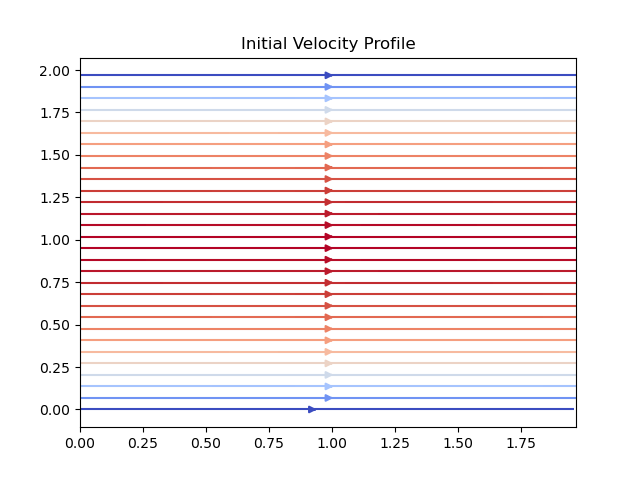

In [3]:
#### Return a Nbx2 array corresponding to a circle of radius RAD centered at position POS
def CIRCLE(Nb, RAD, POS):  
    theta = np.linspace(0, 2*np.pi, Nb)
    return np.array(POS)[None, :] + RAD*np.vstack([np.cos(theta), np.sin(theta)]).transpose()
    
fluid = FLUID(L=2.)
fluid.u = u_pois
fluid.boundary = channel

fig, ax = plt.subplots()
fig.figsize=(8, 8)
fluid.show_streamlines(ax, cmap='coolwarm')
plt.title('Initial Velocity Profile')
plt.show()

circle1 = CIRCLE(100, 0.2, (0.1, 0.3))*fluid.L
circle2 = CIRCLE(100, 0.1, (0.1, 0.8))*fluid.L

solid1 = IB2(circle1, fluid.N, fluid.h, fluid.dt)
solid2 = IB2(circle2, fluid.N, fluid.h, fluid.dt)
solids = [solid1, solid2]

ext = fluid.u*0

Finally, we iterate the system forward in time. Let's also briefly discuss how we're creating the corresponding animations. 

A common way to create animations via matplotlib is using the function plt.animation.FuncAnimation, in which the *data* for a matplotlib object (for example, the y-values of a scatterplot) are specified for each frame in an animation. Here, we use slightly-heavier but still useful the ArtistAnimation function, in which the *artists* are specified on each frame of the animation. *Artists* are matplotlib objects responsible for displaying lines, points, and other visuals in a figure. Many of matplotlib's functions actually return either an artist or a list of artists - for example, plt.imshow() returns an artist corresponding to the output image to be drawn; and plt.plot() returns a list of artists, corresponding to each of the lines to be plotted. 

ArtistAnimation takes as input a list of lists of artists. Each frame corresponds to a particular list of artists to be displayed, while other lists of artists remain hidden. Conceptually, FuncAnimation is like saying "plot *this line* with *different y-values* at each frame", whereas ArtistAnimation is like saying "plot a *different line* at each frame". 

<IPython.core.display.Javascript object>


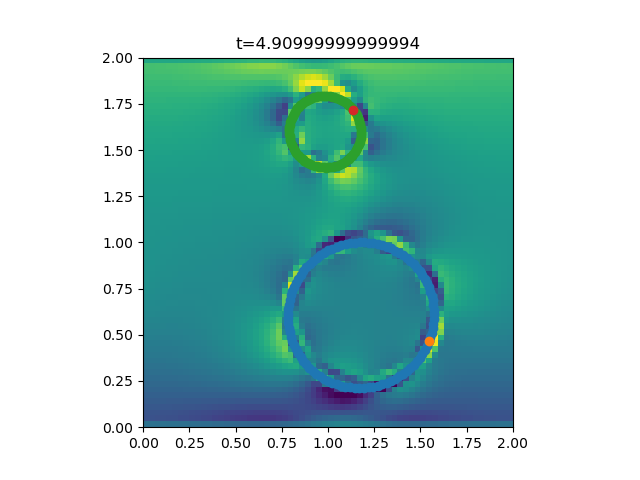

In [4]:
#### Animation
fig, ax = plt.subplots()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(500):
    iterate(fluid, solids, ext=inlet_pressure)
    if i%10==0:
        im = [fluid.show_vorticity(ax)]
#         lines, arrows = fluid.show_streamlines(ax)
#         im.append(lines)
#         im.append(arrows)
        for i, solid in enumerate(solids):
            im.append(plt.scatter(solid.X[:, 0]%fluid.L, solid.X[:, 1]%fluid.L, color=cmap(2*i)))
            im.append(plt.scatter([solid.X[0, 0]%fluid.L], [solid.X[0, 1]%fluid.L], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
ani.save(ani_path+'2D_pois_circles.gif', writer='pillow')


# Another Example: Shear Flow

An interesting aspect of this simulation is that the elastic bodies elastically repel each other without imposing any repulsive forces. In general, an elastic membrane will not "topologically" cross itself, since boundary points move at the fluid velocity and the fluid is incompressible. Likewise, multiple immersed bodies will preserve their own topologies in the same manner, and consequently will not 'penetrate' each other under moderate conditions. 

Likewise, boundaries which are initialized as 'overlapping' will remain overlapped, and 'overlapping' boundaries typically correspond to a system which is not physical.

In [5]:
fluid = FLUID(L=2.)

def shear(u):
    u[0][:, 0] = 1.
    u[0][:,-1] = -1.
    u[1][:, 0] = 0.
    u[1][:,-1] = 0.

fluid.boundary = shear

for i in range(1000):
    fluid.t += fluid.dt
    uu = fluid.step_u(0.)

u_shear = fluid.u

In [ ]:
fluid = FLUID(L=2.)
fluid.u = u_shear
fluid.boundary = shear

fig, ax = plt.subplots()
fig.figsize=(8, 8)
fluid.show_streamlines(ax, cmap='coolwarm')
plt.title('Initial Velocity Profile')
plt.show()

circle1 = CIRCLE(100, 0.18, (0.1, 0.25))*fluid.L
circle2 = CIRCLE(100, 0.18, (0.5, 0.5))*fluid.L
circle3 = CIRCLE(100, 0.18, (0.9, 0.75))*fluid.L

solid1 = IB2(circle1, fluid.N, fluid.h, fluid.dt)
solid2 = IB2(circle2, fluid.N, fluid.h, fluid.dt)
solid3 = IB2(circle3, fluid.N, fluid.h, fluid.dt)
solids = [solid1, solid2, solid3]


#### Animation
fig, ax = plt.subplots()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(700):
    iterate(fluid, solids, ext=ext)
    if i%10==0:
        im = [fluid.show_vorticity(ax)]
#         im.append(fluid.show_streamlines())
        for i, solid in enumerate(solids):
            im.append(ax.scatter(solid.X[:,0]%fluid.L, solid.X[:,1]%fluid.L, color=cmap(2*i)))
            im.append(ax.scatter([solid.X[0,0]%fluid.L], [solid.X[0, 1]%fluid.L], color=cmap(2*i+1)))
#             im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
ani.save(ani_path+'circle_in_init_shear.gif')

        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Several Circles

In [21]:
fluid = FLUID(L=2.)
fluid.u = u_shear
fluid.boundary = shear

plt.figure(figsize=(8, 8))
fluid.show_streamlines(cmap='coolwarm')
plt.title('Initial Velocity Profile')
plt.show()

R = 0.025
solids = []
for i in range(30):
    solids.append(IB2(CIRCLE(25, R, (0.8*np.random.random(size=2)+0.1))*fluid.L, fluid.N, fluid.h, fluid.dt))

#### Animation
fig = plt.figure()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(500):
    iterate(fluid, solids, ext=ext)
    if i%10==0:
        im = [fluid.show_vorticity()]
#         im.append(fluid.show_streamlines())
        for i, solid in enumerate(solids):
            im.append(plt.scatter(solid.X[0]%fluid.L, solid.X[1]%fluid.L, color=cmap(2*i)))
            im.append(plt.scatter([solid.X[0][0]]%fluid.L, [solid.X[1][0]]%fluid.L, color=cmap(2*i+1)))
#             im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        plt.show()
        
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
# # ani.save('circle_in_init_shear.mp4')

# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()        

NameError: name 'u_shear' is not defined

# *DEPRECATED* 
# Two Circles in a Uniform Flow

Let's look at a different configuration:

In [ ]:
fluid = FLUID(L=2.)
fluid.u[1] += 1.
plt.figure(figsize=(8, 8))
fluid.show_streamlines(cmap='autumn')
plt.title('Initial Velocity Profile')
plt.show()

circle = CIRCLE(100, 0.15, (0.3, 0.1))*fluid.L
solids = IB2(circle, fluid.N, fluid.h, fluid.dt)
solids = [solids]



#### Animation
fig = plt.figure()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(600):
    iterate(fluid, solids)
    if i%10==0:
        im = [fluid.show_vorticity()]
#         fluid.show_streamlines()
        for i, solid in enumerate(solids):
            im.append(plt.scatter(solid.X[0], solid.X[1], color=cmap(2*i)))
            im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=100)
# ani.save('dynamic_images.mp4')
plt.show()     



Next, let's try two circles:

<IPython.core.display.Javascript object>


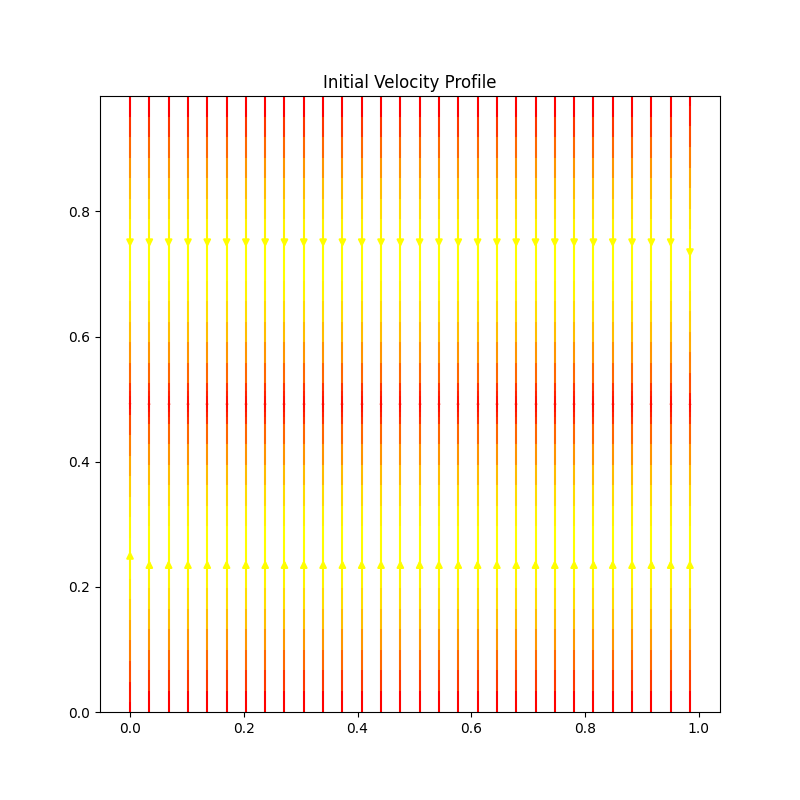

<IPython.core.display.Javascript object>


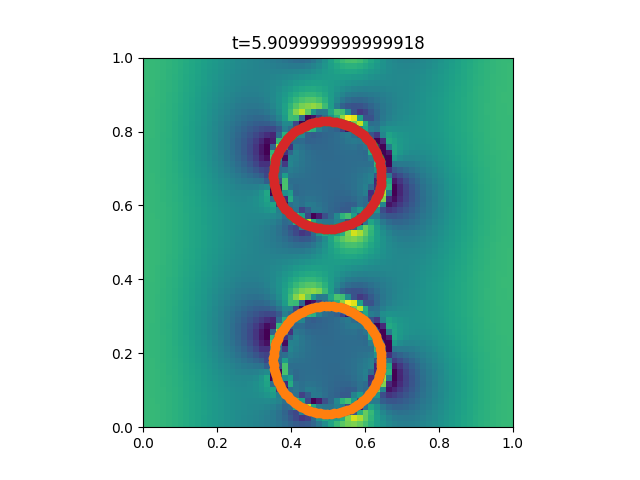

<IPython.core.display.Javascript object>


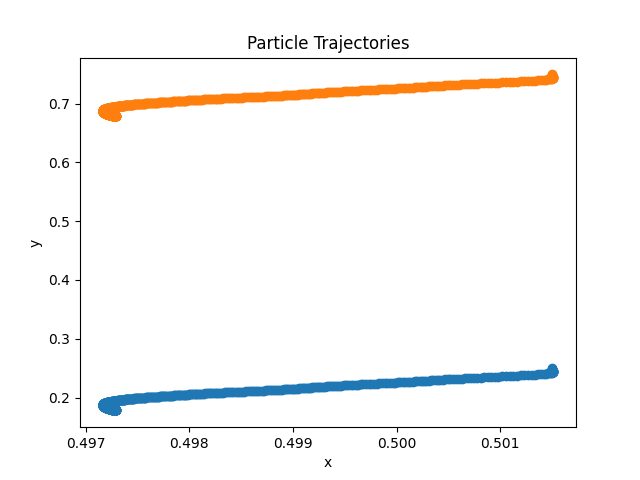

In [15]:
fluid = FLUID()
fluid.u = PLANE_WAVE(fluid.N)
plt.figure(figsize=(8, 8))
fluid.show_streamlines(cmap='autumn')
plt.title('Initial Velocity Profile')
plt.show()

circles = [CIRCLE(100, 0.15, (0.5, 0.5+DY))*fluid.L for DY in [-0.25, 0.25]] 
solids = [IB2(circle, fluid.N, fluid.h, fluid.dt) for circle in circles]

# solids = TWO_CIRCLES(sim.N, sim.h, SEPARATION=.5)
# solids = [CIRCLE(100, sim.N, sim.h, R=.15, R0=(.5, .5))]
# solids = [CIRCLE(100, sim.N, sim.h, R=.25, R0=(.5, .5))]
# for i in range(200):
#     iterate(sim, solids, ext)

    
#### Run the experiment
X1 = []
X2 = []

#### Animation
fig = plt.figure()
fig.figsize=(12, 8)
plt.xlim([0, fluid.L])
plt.ylim([0, fluid.L])

cmap = plt.get_cmap('tab10')
ims = []

for i in range(600):
    iterate(fluid, solids)
    if i%10==0:
        im = [fluid.show_vorticity()]
#         fluid.show_streamlines()
        for i, solid in enumerate(solids):
            im.append(plt.scatter(solid.X[0], solid.X[1], color=cmap(2*i)))
            im.append(plt.scatter(solid.XX[0], solid.XX[1], color=cmap(2*i+1)))
        im.append(plt.title('t={}'.format(1*fluid.t)))
        ims.append(im)
    X1.append(np.sum(solids[0].X, axis=1)/solids[0].Nb)
    X2.append(np.sum(solids[1].X, axis=1)/solids[1].Nb)        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=100)
# ani.save('dynamic_images.mp4')

plt.show()




#### Results
plt.figure()
X1 = np.array(X1)
X2 = np.array(X2)
plt.scatter(X1[:,0], X1[:,1])
plt.scatter(X2[:,0], X2[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Trajectories')
plt.show()



## Some notes about notation

We translate the pibm described here https://math.nyu.edu/faculty/peskin/ib_lecture_notes/KimPeskin_rigid.pdf into python. One aspect of this is vectorizing the matrix operations described in the paper into an efficient numpy formulation. As an illustrative example, take Eq. 19, where we compute the moment of inertia of the rigid body:

$I_0 = \sum_{k=1}^{N_b}m_k(C_K^TC_KI_3 - C_kC_k^T)\Delta q\Delta r\Delta s$

In this case, $C_k$ and $m_k$ describe the coordinates (in rigid body COM frame) and the mass anof each rigid body point $k$; $\Delta q\Delta r\Delta s$ is a scalar factor associated with rigid body point spacing; and $I_3$ is the 3x3 identity matrix. In particular, we'd like to translate this quantity

$\sum_{k=1}^{N_b}C_K^TC_KI_2 - C_kC_k^T$

into python. (Note that we switch to $I_2$ because we're working in 2D). This can of course be computed using loops, but we show that these expressions can be equivalently expressed using inner and outer products:

(2, 100)


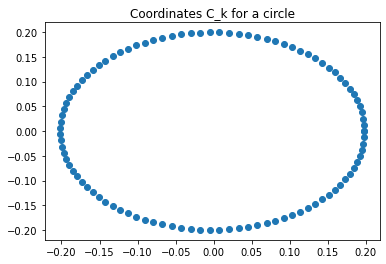

In [28]:
def CIRCLE(Nb, RAD, POS):  
    theta = np.linspace(0, 2*np.pi, Nb)
    return np.array(POS)[:, np.newaxis] + RAD*np.array([np.cos(theta), np.sin(theta)])

circle = CIRCLE(100, 0.2, (0.5, 0.5))
circle -= np.mean(circle, axis=1)[:, np.newaxis]
print(np.shape(circle))
plt.scatter(circle[0], circle[1])
plt.title('Coordinates C_k for a circle')
plt.show()

In [3]:
#### First, let's calculate the sum explicitly using loops:

print('Using Sums:')
TERM1 = [np.inner(circle[:,i], circle[:,i]) for i in range(circle.shape[1])]
TERM1 = sum([val*np.eye(2) for val in TERM1])
print('Sum of First Terms')
print(TERM1)
print()

TERM2 = [np.outer(circle[:,i], circle[:,i]) for i in range(circle.shape[1])]
TERM2 = sum(TERM2)
print('Sum of Second Terms')
print(TERM2)
print()

print('Total sum:')
print(TERM1 - TERM2)
print()
print()

#### Now, let's compute the equivalent, vectorized code. We note that the first term is simply the sum of |C_k|^2,
#### and the second term is a sum of outer products, which is equivalent to an inner product (or contraction) of 
####   the TENSOR C of all C_k's with itself:
print('Vectorized:')

TERM1 = sum(np.linalg.norm(circle, axis=0)**2)*np.eye(2)
print('Sum of first terms (i.e. norm):')
print(TERM1)
print()

TERM2 = np.inner(circle, circle)
print('Sum of second terms (i.e. inner product):')
print(TERM2)
print()

print('Total sum:')
print(TERM1 - TERM2)

Using Sums:
Sum of First Terms
[[216.8   0. ]
 [  0.  216.8]]

Sum of Second Terms
[[108.88 100.4 ]
 [100.4  107.92]]

Total sum:
[[ 107.92 -100.4 ]
 [-100.4   108.88]]


Vectorized:
Sum of first terms (i.e. norm):
[[216.8   0. ]
 [  0.  216.8]]

Sum of second terms (i.e. inner product):
[[108.88 100.4 ]
 [100.4  107.92]]

Total sum:
[[ 107.92 -100.4 ]
 [-100.4   108.88]]


In [5]:
import numpy as np

A = (10*np.random.random([3, 3])).astype(int)
B = (10*np.random.random([3, 3])).astype(int)
I3 = np.eye(3)
print(A)
print(B)
print(I3)

[[4 5 6]
 [8 3 3]
 [6 0 8]]
[[6 9 7]
 [8 1 2]
 [1 3 4]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [17]:
print(np.matmul(A, B))
print()
print(A.dot(B))
print()
print(B.dot(A))
print()
print(A.transpose().dot(B.transpose()))
print()

[[70 59 62]
 [75 84 74]
 [44 78 74]]

[[70 59 62]
 [75 84 74]
 [44 78 74]]

[[138  57 119]
 [ 52  43  67]
 [ 52  14  47]]

[[138  52  52]
 [ 57  43  14]
 [119  67  47]]



In [16]:
print(A.dot(A.transpose()))
print()

[[ 77  65  72]
 [ 65  82  72]
 [ 72  72 100]]



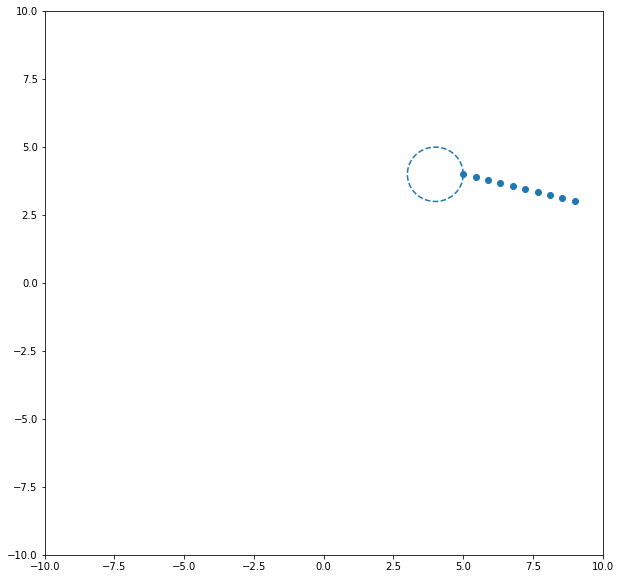

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def rot(ax, theta, X): return np.cos(theta)*X + (1-np.cos(theta))*np.dot(ax, X)*ax + np.sin(theta)*np.cross(ax, X)


I2 = np.eye(2)

X = np.linspace(5, 9, 10)
Y = np.linspace(4, 3, 10)
R = np.vstack([X, Y])
RCM = np.array([4, 4])
theta = np.linspace(0, 2*np.pi, 100)

plt.figure(figsize=(10,10))
plt.plot(RCM[0]+np.cos(theta), RCM[1]+np.sin(theta), linestyle='--')
plt.scatter(R[0], R[1])
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()



[1. 0.]
(2, 10)
[[5.         5.44444444 5.88888889 6.33333333 6.77777778 7.22222222
  7.66666667 8.11111111 8.55555556 9.        ]
 [4.         3.88888889 3.77777778 3.66666667 3.55555556 3.44444444
  3.33333333 3.22222222 3.11111111 3.        ]]


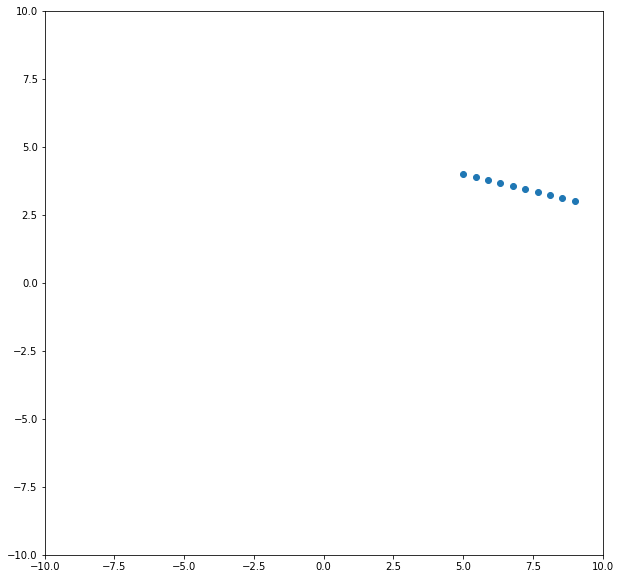

In [59]:
plt.figure(figsize=(10,10))
plt.plot(RCM[0]+np.cos(theta), RCM[1]+np.sin(theta), linestyle='--')
plt.scatter(R[0], R[1])
plt.xlim([-10, 10])
plt.ylim([-10, 10])



ax = R[:, 0]-RCM
print(ax)
theta = np.pi/4

Rr = [rot(ax, theta, R[:,i]) for i in range(R.shape[1])]
Rr = np.vstack(Rr).transpose()
Rr = [rot(ax, theta, Rr[:,i]) for i in range(Rr.shape[1])]
Rr = np.vstack(Rr).transpose()
print(np.shape(Rr))
print(R)
plt.scatter(Rr[0], Rr[1])
plt.show()




[1. 0.]
(2, 10)


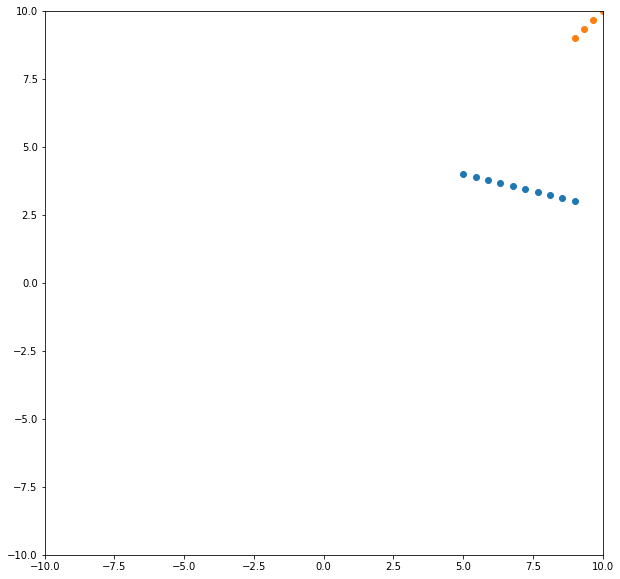

In [54]:
def rot(ax, theta, X): 
    out = np.cos(theta)*X 
    out += (1-np.cos(theta))*np.dot(ax, X) 
    out += np.sin(theta)*np.cross(ax, X, axisb=0)
    return out

plt.figure(figsize=(10,10))
plt.plot(RCM[0]+np.cos(theta), RCM[1]+np.sin(theta), linestyle='--')
plt.scatter(R[0], R[1])
plt.xlim([-10, 10])
plt.ylim([-10, 10])



ax = R[:, 0]-RCM
print(ax)
# theta = np.pi/4
theta=np.pi/2

print(np.shape(R))
Rr = rot(ax, theta, R)
# Rr = rot(ax, theta, Rr)
# Rr = rot(ax, theta, Rr)
# Rr = rot(ax, theta, Rr)

plt.scatter(Rr[0], Rr[1])
plt.show()
